# Importing Modules

In [1]:
# import some common libraries
import numpy as np
import os, json, cv2, random

import os
import json
import pandas as pd
from pycocotools.coco import COCO
from tqdm import tqdm  # Import tqdm for progress bar
import numpy as np  # Ensure numpy is imported for mask operations
import cv2

from matplotlib import pyplot as plt

import pycocotools.mask as mask_util

from typing import List
import os

import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
from tqdm import tqdm
import seaborn as sns

import torch

# Load performance for native unet and focused unet with different focus crop ratios

In [2]:
res_dir = "./"

results = {}
for p in os.listdir(res_dir):
	if os.path.isdir(os.path.join(res_dir, p)):
		with open(os.path.join(res_dir, p, 'sem_seg_evaluation.pth'), 'rb') as f:
			res = torch.load(f)
			results[p] = res

In [3]:
all_res_df = pd.DataFrame(results)
all_res_df

,r_01,native_unet,r_07,r_04,r_50,r_100,r_10,r_20
turtle_miou,0.848738,0.818001,0.840500,0.846431,0.821849,0.819489,0.836028,0.828368
flippers_miou,0.689948,0.608247,0.660185,0.684141,0.608233,0.608319,0.642548,0.616270
head_miou,0.672542,0.594467,0.639247,0.661658,0.594951,0.594457,0.625106,0.603577
average_miou,0.737076,0.673572,0.713311,0.730743,0.675011,0.674088,0.701227,0.682739


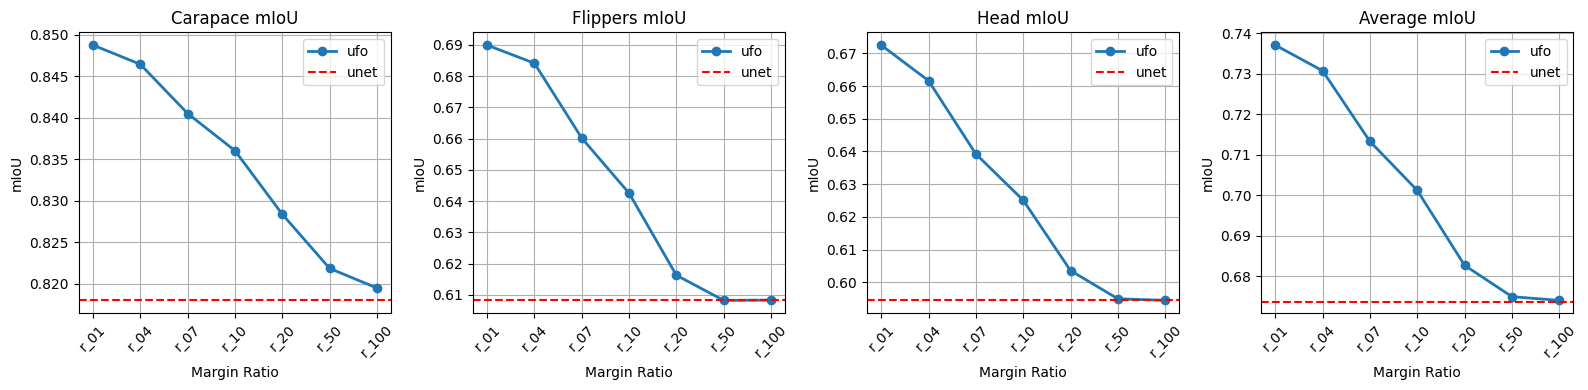

In [4]:
# Define the method order and extract the relevant values
ordered_methods = ["r_01", "r_04", "r_07", "r_10", "r_20", "r_50", "r_100"]
native_unet_value = all_res_df["native_unet"]

# Extract mIoU values for each category based on the ordered methods
turtle_miou = all_res_df.loc["turtle_miou", ordered_methods]
flippers_miou = all_res_df.loc["flippers_miou", ordered_methods]
head_miou = all_res_df.loc["head_miou", ordered_methods]
average_miou = all_res_df.loc["average_miou", ordered_methods]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
categories = ["Carapace", "Flippers", "Head", "Average"]
miou_data = [turtle_miou, flippers_miou, head_miou, average_miou]

# Plotting each category with the ordered x-axis and horizontal line for native_unet
for i, (ax, data, category) in enumerate(zip(axs.flatten(), miou_data, categories)):
    ax.plot(ordered_methods, data, marker='o', linestyle='-', linewidth=2, label="ufo")
    ax.axhline(native_unet_value.iloc[i], color='red', linestyle='--', label="unet")
    ax.set_title(f"{category} mIoU")
    ax.set_xlabel("Margin Ratio")
    ax.set_ylabel("mIoU")
    ax.set_xticks(np.arange(len(ordered_methods)))
    ax.set_xticklabels(ordered_methods, rotation=45)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [5]:
with open('./r_01/sem_seg_predictions.json', 'r') as f:
    raw_ufo_res = json.load(f)
    
with open('./native_unet/sem_seg_predictions.json', 'r') as f:
    raw_unet_res = json.load(f)

In [6]:
def visualize_mask(masks_dict):
    # Decode the RLE mask
    mask = mask_util.decode(masks_dict)

    # Plot the mask
    plt.figure(figsize=(6, 4))
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

def iou(gt_mask, pred_mask):
    """Calculate Intersection over Union (IoU) for two masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

def evaluate(res):
    eval_res = {}
    for img_id, item in tqdm(res.items()):
        eval_res[img_id] = {}
        for _id, gt in item['gt'].items():
            gt_mask = mask_util.decode(gt)
            if str(_id) in item['pred']:
                pred_mask = mask_util.decode(item['pred'][str(_id)])
                iou_score = iou(gt_mask, pred_mask)
            else:
                iou_score = 0.0
            eval_res[img_id][_id] = iou_score
    return eval_res

In [7]:
ufo_res = evaluate(raw_ufo_res)
unet_res = evaluate(raw_unet_res)

100%|██████████| 2308/2308 [00:58<00:00, 39.25it/s]


In [8]:
ufo_res_df = pd.DataFrame(ufo_res).transpose().fillna(0)
unet_res_df = pd.DataFrame(unet_res).transpose().fillna(0)

In [9]:
print("U-Net Results:")
print("Background IoU: ", unet_res_df['0'].mean())
print("Carapace IoU: ", unet_res_df['1'].mean())
print("Flipper IoU: ", unet_res_df['2'].mean())
print("Head IoU: ", unet_res_df['3'].mean())
print("Average IoU: ", (unet_res_df['1'].mean() + unet_res_df['2'].mean() + unet_res_df['3'].mean()) / 3)

print("-"*10)

print("UFO Results:")
print("Background IoU: ", ufo_res_df['0'].mean())
print("Carapace IoU: ", ufo_res_df['1'].mean())
print("Flipper IoU: ", ufo_res_df['2'].mean())
print("Head IoU: ", ufo_res_df['3'].mean())
print("Average IoU: ", (ufo_res_df['1'].mean() + ufo_res_df['2'].mean() + ufo_res_df['3'].mean()) / 3)

U-Net Results:
Background IoU:  0.9889077665892053
Carapace IoU:  0.8180007249333971
Flipper IoU:  0.6082467636585109
Head IoU:  0.5944671086834804
Average IoU:  0.6735715324251296
----------
UFO Results:
Background IoU:  0.9905837792652703
Carapace IoU:  0.8487382822234224
Flipper IoU:  0.689948253706394
Head IoU:  0.6725424684209033
Average IoU:  0.7370763347835733


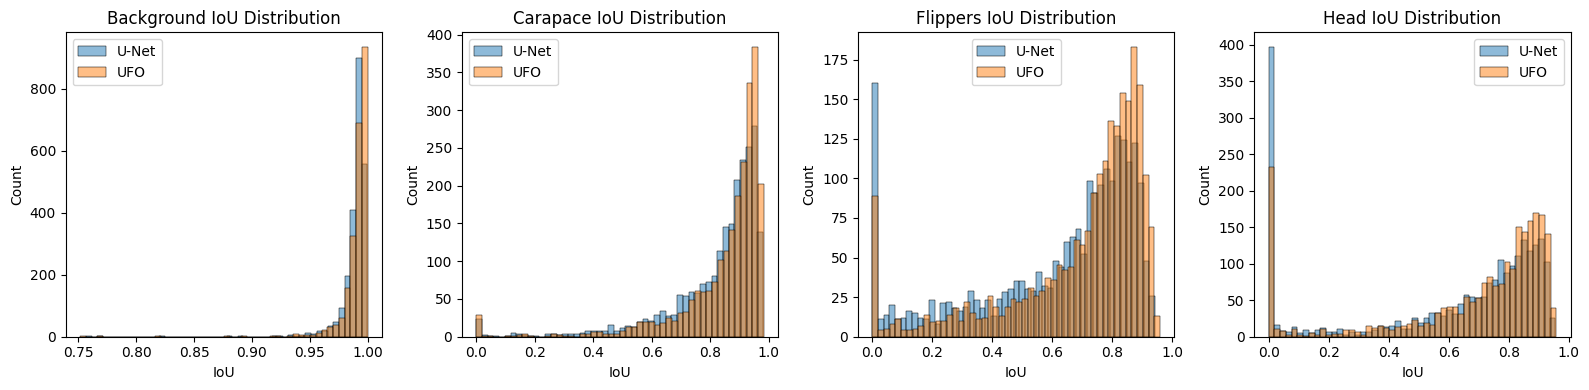

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
bins = 50  # Set consistent number of bins

# Background (0)
sns.histplot(data=unet_res_df['0'], ax=axes[0], bins=bins, label='U-Net', alpha=0.5)
sns.histplot(data=ufo_res_df['0'], ax=axes[0], bins=bins, label='UFO', alpha=0.5)
axes[0].set_xlabel('IoU')
axes[0].set_title('Background IoU Distribution')
axes[0].legend()

# Carapace (1) 
sns.histplot(data=unet_res_df['1'], ax=axes[1], bins=bins, label='U-Net', alpha=0.5)
sns.histplot(data=ufo_res_df['1'], ax=axes[1], bins=bins, label='UFO', alpha=0.5)
axes[1].set_xlabel('IoU')
axes[1].set_title('Carapace IoU Distribution')
axes[1].legend()

# Flippers (2)
sns.histplot(data=unet_res_df['2'], ax=axes[2], bins=bins, label='U-Net', alpha=0.5)
sns.histplot(data=ufo_res_df['2'], ax=axes[2], bins=bins, label='UFO', alpha=0.5)
axes[2].set_xlabel('IoU')
axes[2].set_title('Flippers IoU Distribution')
axes[2].legend()

# Head (3)
sns.histplot(data=unet_res_df['3'], ax=axes[3], bins=bins, label='U-Net', alpha=0.5)
sns.histplot(data=ufo_res_df['3'], ax=axes[3], bins=bins, label='UFO', alpha=0.5)
axes[3].set_xlabel('IoU')
axes[3].set_title('Head IoU Distribution')
axes[3].legend()

plt.tight_layout()
plt.show()


In [19]:
# Merge the unet and ufo per category mIoU for comparison
comparison_df = pd.merge(
  unet_res_df,
  ufo_res_df,
  on=unet_res_df.index,
  suffixes=('_unet', '_ufo')
).rename(columns={"key_0": "img_id"})

# Function to get the most improved or degraded cases
def get_most(mode="good", top_n=10, part="1"):
    if mode == "good":
        comparison_df[f"{part}_improvement"] = comparison_df[f"{part}_ufo"] - comparison_df[f"{part}_unet"]
        return comparison_df.sort_values(by=f"{part}_improvement", ascending=False).head(top_n)
    else:
        comparison_df[f"{part}_improvement"] = comparison_df[f"{part}_ufo"] - comparison_df[f"{part}_unet"]
        return comparison_df.sort_values(by=f"{part}_improvement", ascending=True).head(top_n)

In [21]:
# Get top 10 largest improvement for flippers (1)
get_most(mode="good", top_n=10, part="1")

,img_id,0_unet,1_unet,2_unet,3_unet,0_ufo,1_ufo,2_ufo,3_ufo,1_improvement
1088,7050,0.998632,0.000000,0.087763,0.000000,0.998814,0.832136,0.288855,0.459276,0.832136
1965,8387,0.998026,0.069136,0.000000,0.048966,0.998543,0.804792,0.000000,0.000000,0.735655
607,4903,0.996798,0.122171,0.141707,0.002395,0.997953,0.810151,0.499071,0.683149,0.687980
1196,7618,0.997538,0.139232,0.124781,0.000000,0.998088,0.826170,0.184491,0.000851,0.686937
1883,8305,0.975170,0.150971,0.000000,0.106835,0.988550,0.836473,0.415623,0.709569,0.685502
1759,8181,0.986225,0.125085,0.501268,0.429177,0.995798,0.743584,0.616537,0.832572,0.618499
2148,8570,0.997725,0.237551,0.049916,0.000000,0.998136,0.831095,0.268315,0.000000,0.593544
2286,8708,0.997569,0.049442,0.114398,0.000000,0.997123,0.640378,0.215739,0.000000,0.590935
535,4588,0.982723,0.328183,0.257250,0.057152,0.981392,0.824200,0.392104,0.000000,0.496017
1200,7622,0.996160,0.417256,0.136466,0.000000,0.997241,0.896767,0.225455,0.000000,0.479511


In [22]:
# Get top 10 largest degradation cases for flippers (1)
get_most(mode="bad", top_n=10, part="1")

,img_id,0_unet,1_unet,2_unet,3_unet,0_ufo,1_ufo,2_ufo,3_ufo,1_improvement
84,827,0.998754,0.583674,0.000000,0.000000,0.997265,0.000429,0.000000,0.000000,-0.583245
1563,7985,0.998802,0.690566,0.000000,0.000000,0.997282,0.260848,0.000000,0.000000,-0.429719
1942,8364,0.998664,0.688705,0.000000,0.000000,0.997603,0.266107,0.000000,0.000000,-0.422598
1041,6852,0.983565,0.564838,0.286476,0.000000,0.970238,0.148977,0.000000,0.002253,-0.415861
262,1975,0.996112,0.797186,0.259283,0.675682,0.953298,0.394747,0.322614,0.704037,-0.402439
2221,8643,0.995886,0.718679,0.000000,0.000000,0.992446,0.378192,0.000000,0.000000,-0.340487
1922,8344,0.997848,0.473290,0.000000,0.000000,0.996907,0.162639,0.000000,0.000000,-0.310651
970,6678,0.997942,0.589109,0.000000,0.000000,0.996269,0.279368,0.000000,0.000000,-0.309742
1858,8280,0.994693,0.331868,0.000000,0.000000,0.993071,0.046453,0.000000,0.000000,-0.285415
2113,8535,0.996707,0.842627,0.192862,0.000000,0.990751,0.572772,0.389351,0.000000,-0.269856


# Load original dataset and visualize the cases

In [23]:
data_dir = "../../turtles-data/data" # Change this to your data directory

coco = COCO(os.path.join(data_dir, "annotations.json"))

loading annotations into memory...
Done (t=4.99s)
creating index...
index created!


8212


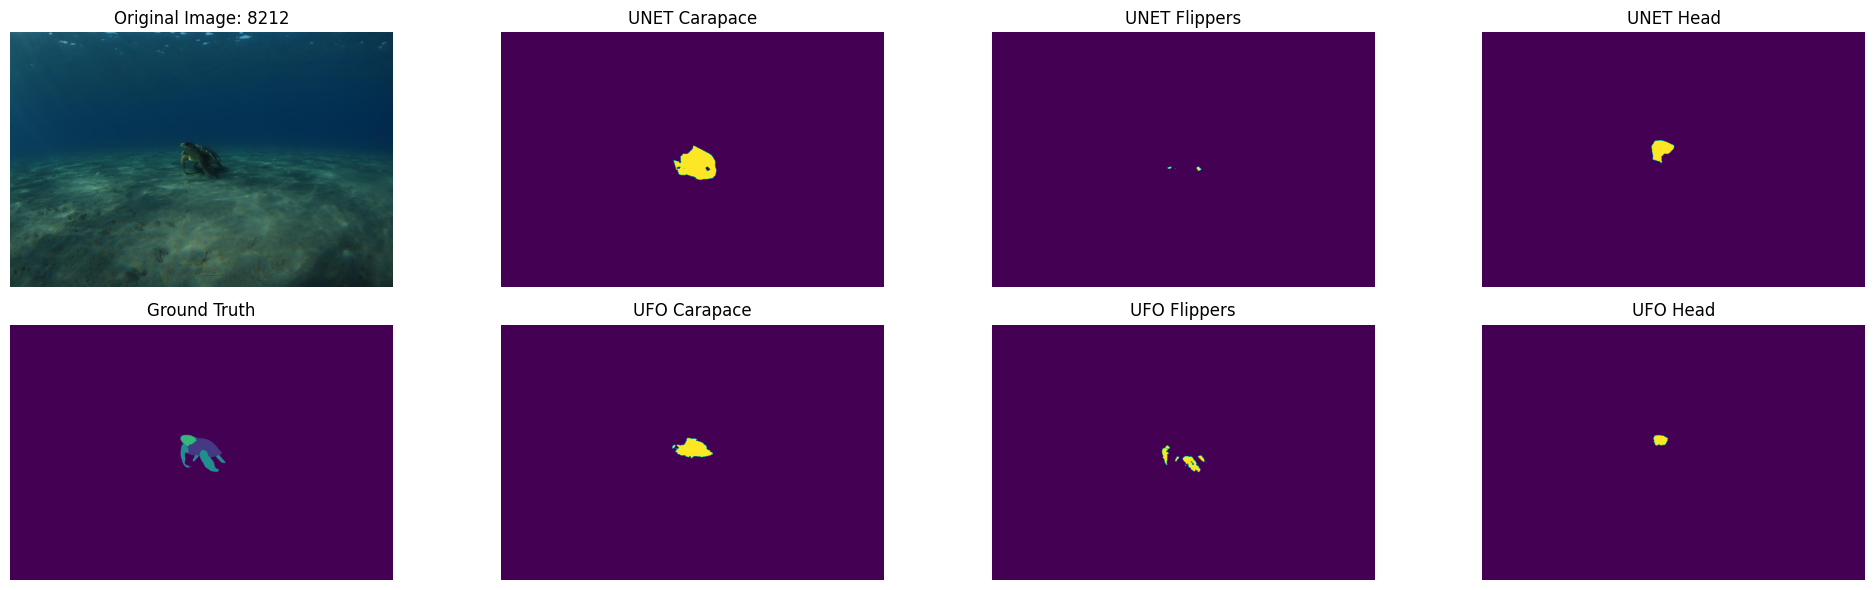

In [48]:
# Check the most improved cases
idx = get_most(mode="good", top_n=100, part="1").iloc[13]["img_id"]
print(idx)

# Plot the masks side by side
fig, axes = plt.subplots(2, 4, figsize=(20, 6))

img_id = int(idx)
img_info = coco.loadImgs(img_id)[0]
img = cv2.imread(os.path.join(data_dir, f'{img_info["file_name"]}'), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Original image
axes[0,0].imshow(img.astype(np.uint8))
axes[0,0].set_title(f'Original Image: {img_id}')
axes[0,0].axis('off')

parts = ['1', '2', '3']
titles = ['Carapace', 'Flippers', 'Head']

# Ground truth masks at (1, 0)
gt_combined = np.zeros(img.shape[:2], dtype=np.int32)  # Changed img.size[::-1] to img.shape[:2]
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
for ann in anns:
    cat_id = ann['category_id']
    mask = coco.annToMask(ann)
    gt_combined += mask * cat_id

axes[1, 0].imshow(gt_combined)  # Changed axs to axes to match variable name
axes[1, 0].set_title('Ground Truth')
axes[1, 0].axis('off')

# UNET prediction row
for i, (part, title) in enumerate(zip(parts, titles)):
    try:
        axes[0,i+1].imshow(mask_util.decode(raw_unet_res[f'{idx}']['pred'][part]))
        axes[0,i+1].set_title(f'UNET {title}')
    except KeyError:
        axes[0,i+1].set_title(f'UNET {title} (Missing)')
    axes[0,i+1].axis('off')

# UFO prediction row
for i, (part, title) in enumerate(zip(parts, titles)):
    try:
        axes[1,i+1].imshow(mask_util.decode(raw_ufo_res[f'{idx}']['pred'][part]))
        axes[1,i+1].set_title(f'UFO {title}')
    except KeyError:
        axes[1,i+1].set_title(f'UFO {title} (Missing)')
    axes[1,i+1].axis('off')

# Remove unused axes
for ax in axes.flat[8:]:
    ax.remove()

plt.tight_layout()
plt.show()